In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pandas as pd

In [3]:
import measures as nolds

In [4]:
def var(u_e):
    return np.var(u_e)

def freq(u_e):
    ind = argrelextrema(np.array(u_e), np.greater)
#     print(ind)
    diffs = np.diff(argrelextrema(np.array(u_e), np.greater))
#     print(diffs)
    n = int(len(diffs)/2)
    sub_ind = diffs[n-1:n+1]
    abso = np.absolute(sub_ind)
#   print(mean(abso), "here")
    #print(1/(0.01*mean(abso)))
    freq = 1/np.mean(abso)
    return 1/(0.01*np.mean(abso))
#TIME STEP IS SIZE 0.01

#print(freq(G[:,0]),freq(G[:,1]))

In [5]:
#FINAL ONE
#param
freq_x = []
freq_y = []
var_x =[]
z_list = list(np.arange(-3,0,0.1))
for z in z_list:
    #print(z)
    alpha = 3
    a = 0.7
    b = 0.8
    omega_sq = 1
    #model -> G[x,y]

    def model(G,t):
        return np.array([ alpha*(G[1] + G[0] - ((G[0]**3)/3) + z), -(1/alpha)*(G[0] - a + (b*G[1]) )])

    t = np.linspace(0, 100,  10000)              # time step
    G0 = np.array([0, 0])                     # initials conditions
    G = odeint(model, G0, t)

#     plt.show()
    freq_x.append(freq(G[:,0]))
    var_x.append(var(G[5000:,0]))
    freq_y.append(freq(G[:,1]))



/scinet/gpc/Applications/anaconda3/4.2.0_hub/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [6]:
#fixing the frequencies

freq_new = []

for i in range(len(z_list)):
    if var_x[i] < 0.1:
        freq_new.append(0)
    else:
        freq_new.append(freq_x[i])


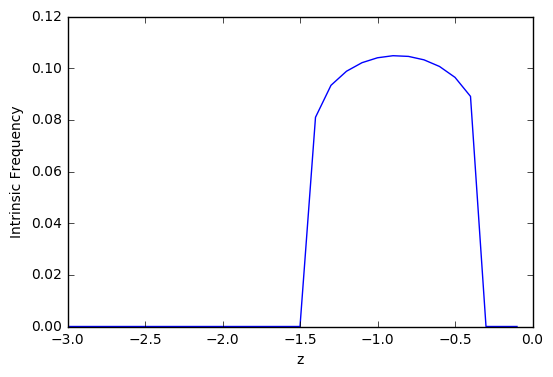

In [7]:
# #FINAL PLOT
plt.plot(z_list, freq_new)
plt.xlabel("z")
plt.ylabel("Intrinsic Frequency")
plt.show()
# freq_new

In [8]:
#GETTING THE VALUES FOR K1 AND K2
table = [z_list, freq_new]


k1_col = []
k1freq = []
k2_col = []
k2freq = []
perc_diff = []

k_freq = np.transpose(table)[16:-2]
k_freq
num_k_vals = np.shape(k_freq)[0] #num of rows

#k_freq is a 12x2 array with k values in first column and the corresponding freq in second, it contains the subset of k that 
#actually result in oscillations

for i in range(num_k_vals):
    for j in range(i,num_k_vals):
        #appending the k1 value from the ith row in the first column of k_freq
        k1_col.append(k_freq[:,0][i])
        #appending the k1 frequency from the ith row in the second column of k_freq
        k1freq.append(k_freq[:,1][i])
        k2_col.append(k_freq[:,0][j])
        k2freq.append(k_freq[:,1][j])
        
        #calculating the percent difference in frequencies
        perc = (1- (min(k_freq[j,1],k_freq[i,1])/max(k_freq[j,1],k_freq[i,1])))*100
        perc_diff.append(perc)

In [9]:
#converting to dataframe to see what data looks like
d = {'k1': k1_col, 'freq1': k1freq, 'k2': k2_col, 'freq2': k2freq, 'perc_diff': perc_diff}
df = pd.DataFrame(data=d)
#df

In [10]:
#FINAL PERCENT DIFFERENCE COLUMN
df_sorted = df.sort_values('perc_diff')
df_single = df_sorted.drop_duplicates('perc_diff')
df_final= df_single.drop(77)
#df_final

In [11]:
#fixing the perc diff values -- final_df_numpy
df_numpy = df_final.values
arr_perc_diff = df_numpy[:,4] #saving the 5th column (the percent differences)

indices = [len(arr_perc_diff)-1] #saving a list of indices to remove rows from df_numpy becuase we don't want
                                        #we don't want freq diff too close to one another
                                        #the first element is the last index bc we dont want 100% diff (skews graph)
first_diff = np.round(np.diff(arr_perc_diff))

#going through first difference
for i in range(len(first_diff)):
    if first_diff[i] < 1:
        indices.append(i)

final_df_numpy = np.delete(df_numpy, indices, 0)
#now final_df_numpy is same as df_numpy except a bunch of rows removed that we don't need
print(final_df_numpy[:,4])
print(np.shape(final_df_numpy))

[  2.57574038   5.7312253    6.56879554   7.99399914   8.56935367
  10.92436975  11.50700862  13.70423981  15.02059904  16.03167258
  18.04720037  19.54984832  20.70157849  21.54738033  22.74409995]
(15, 5)


In [12]:
#PART 2, PLOTTING COUPLED OSCI
#The following code defines the "right hand side" of the system of equations (also known as a vector field). 

from scipy.integrate import odeint
import matplotlib.pyplot as plt

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [alpha, k1, k2, c, b,a]
    """
    x1, y1, x2, y2 = w
    alpha, k1, k2, c, b, a = p

    # Create f = (x1',y1',x2',y2'):
    f = [ alpha*(y1 + x1 - ((x1**3)/3) + k1+ c*x2),
         -(1/alpha)*( x1- a + (b*y1)), 
         alpha*(y2 + x2 - ((x2**3)/3) + k2+ c*x1),
        -(1/alpha)*( x2- a + (b*y2))]
    
    return f

In [14]:
# Use ODEINT to solve the differential equations defined by the vector field
solution_list = [] #from this we can get time series for everything

freq_listx1 = []
freq_listx2 = []

var_listx1 = []
var_listx2 = []

x1ts_list = []
x2ts_list = []

c_list = np.linspace(0,1,20)

#for each row in final_df_numpy set the k1 and k2
for i in range(np.shape(final_df_numpy)[0]):
    k1 = final_df_numpy[i,2]
    k2 = final_df_numpy[i,3]
    
    for c in c_list:

        # Parameter values
        alpha = 3
        a = 0.7
        b = 0.8

        # Initial conditions
        x1 = 0.0
        y1 = 0.0
        x2 = 0.0
        y2 = 0.0

        # Pack up the parameters and initial conditions:
        p = [alpha, k1, k2, c, b, a]
        w0 = [x1, y1, x2, y2]
        t = np.linspace(0, 100,  10000)              # time step

        #Call the ODE solver.
        wsol = odeint(vectorfield, w0, t, args=(p,))
        
        x1= wsol[:,0]
        x2= wsol[:,2]
        

        solution_list.append(wsol)
        
        freq_listx1.append(freq(x1))
        freq_listx2.append(freq(x2))
        
        var_listx2.append(var(x2))
        var_listx1.append(var(x1))

        x1ts_list.append(x1)
        x2ts_list.append(x2)

# np.save('x1ts_list20.npy', x1ts_list)
# np.save('x2ts_list20.npy',x2ts_list)

/scinet/gpc/Applications/anaconda3/4.2.0_hub/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [15]:
#fixing the frequencies x1 and x2

freq_newx1b = []
freq_newx2b = []
num_runs = len(var_listx1)
print(num_runs)
for i in range(num_runs):
    if var_listx1[i] < 0.1:
        freq_newx1b.append(0)
    if var_listx2[i] < 0.1:
        freq_newx2b.append(0)
    
    if var_listx1[i] >= 0.1:
        freq_newx1b.append(freq_listx1[i])
    if var_listx2[i] >= 0.1:
        freq_newx2b.append(freq_listx2[i])

300


In [16]:
#data to use for the rest of the proj
# x axis - c_list

#y_axis
perc_diff_list = final_df_numpy[:,4]

print(len(c_list), len(perc_diff_list))
print(num_runs, len(x1ts_list), len(c_list)*len(perc_diff_list))

20 15
300 300 300


In [21]:
#MAXIMUM LYAPUNOV EXPONENT
rwalk = np.cumsum(np.random.random(1000))
h = nolds.dfa(rwalk)
h

2.0351508123487569

In [ ]:
max_lyap_x1 = []
max_lyap_x2 = []
# posx1_ind = []
# posx2_ind = []

for i in range(num_runs):
    lx1 = nolds.lyap_r(x1ts_list[i])
    lx2 = nolds.lyap_r(x2ts_list[i])
    
    max_lyap_x1.append(lx1)
    max_lyap_x2.append(lx2)
    
#     if lx1 > 0:
#         posx1_ind.append(i)
#     if lx2 > 0:
#         posx2_ind.append(i)

np.save('max_lyap_x1_20.npy', max_lyap_x1)
np.save('max_lyap_x1_20.npy', max_lyap_x2)

layp x1


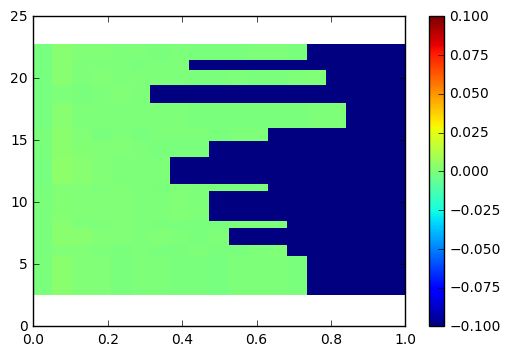

layp x2


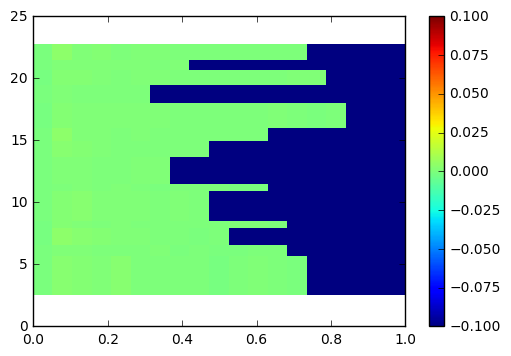

In [26]:
#PLOTTING LYAP FOR X1
print("layp x1")
x=c_list
y=perc_diff_list
z=np.array(max_lyap_x1)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

#phase_list is arranged so that its a sequence of 15 groups, each of 50 values (for diff c), since numpy is row-major, it'll
#fill array by rows, so you want there to be 15 rows, and 50 columns

Z= z.reshape(len(y),len(x))

plt.pcolormesh(X,Y,Z)
plt.colorbar()

plt.show()

#PLOTTING LYAP FOR X2
print("layp x2")

x=c_list
y=perc_diff_list
z=np.array(max_lyap_x2)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

#phase_list is arranged so that its a sequence of 15 groups, each of 50 values (for diff c), since numpy is row-major, it'll
#fill array by rows, so you want there to be 15 rows, and 50 columns

Z= z.reshape(len(y),len(x))

# plt.pcolormesh(X,Y,Z,edgecolor='k')
plt.pcolormesh(X,Y,Z)
plt.colorbar()

plt.show()

In [ ]:
1+1

In [ ]:
dim_x1 = []
dim_x2 = []

for i in range(num_runs):
    print(num_runs-1-i)
    dx1 = nolds.corr_dim(x1ts_list[num_runs-1-i],10)
    dx2 = nolds.corr_dim(x2ts_list[num_runs-1-i],10)
    
    dim_x1.append(dx1)
    dim_x2.append(dx2)

np.save('dim_x1_rev.npy', dim_x1)
np.save('dim_x2_rev.npy', dim_x2)

299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89


KeyboardInterrupt: 

In [ ]:
#PLOTTING DIM FOR X1
print("DIM x1")
x=c_list
y=perc_diff_list
z=np.array(dim_x1)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z= z.reshape(len(y),len(x))

plt.pcolormesh(X,Y,Z)
plt.colorbar()

plt.show()

#PLOTTING LYAP FOR X2
print("DIM x2")

x=c_list
y=perc_diff_list
z=np.array(dim_x2)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z= z.reshape(len(y),len(x))

plt.pcolormesh(X,Y,Z)
plt.colorbar()

plt.show()